# Exploitation des résultats UMAP

La semaine dernière, nous avions récupéré la sortie de l'exploration par [UMAP](https://umap-learn.readthedocs.io/en/latest/index.html) et présenté brièvement la réduction / projection en 3 dimensions.

## 1. Préparation des données

In [1]:
# Append module location to sys.path
import sys, pathlib, os
pkg_path = pathlib.Path().cwd().parent
sys.path.append(pkg_path.as_posix())
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from yawbcc.datasets import load_barcelona_wbc

sns.set_theme()

In [3]:
# Load data and meta data
umap = pd.read_csv('umap.csv')
meta = load_barcelona_wbc()

display(umap.head())
display(meta.head())

,x,y,z
0,8.523534,4.694407,8.721131
1,8.064334,5.029300,8.466122
2,7.781055,5.814685,8.475002
3,8.550620,4.982080,8.688944
4,9.171330,6.459671,8.470358


,image,group,label,width,height,path
0,MO_322276.jpg,MONOCYTE,MO,360,363,/home/damien/yawbcc_data/barcelona/monocyte/MO...
1,MO_542415.jpg,MONOCYTE,MO,360,363,/home/damien/yawbcc_data/barcelona/monocyte/MO...
2,MO_657991.jpg,MONOCYTE,MO,360,363,/home/damien/yawbcc_data/barcelona/monocyte/MO...
3,MO_372163.jpg,MONOCYTE,MO,360,363,/home/damien/yawbcc_data/barcelona/monocyte/MO...
4,MO_237869.jpg,MONOCYTE,MO,360,363,/home/damien/yawbcc_data/barcelona/monocyte/MO...


## 2. Visualisation des résultats

Dans la figure 3D ci-dessous, nous voyons une certaine séparation des classes

### A. Représentation en 3D

Il y a vraiment une différenciation des images entre les groupes. Néanmoins, nous constatons des valeurs parasites au sein des grandes concentrations.

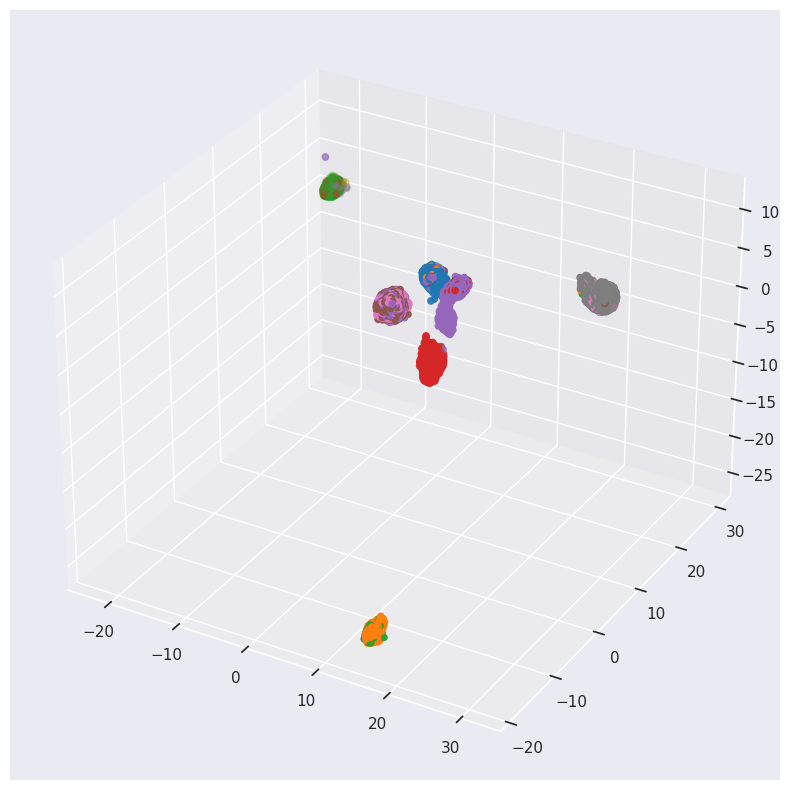

In [4]:
palette = dict(zip(meta['group'].unique(), sns.color_palette('tab10', n_colors=meta['group'].nunique())))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(umap['x'], umap['y'], umap['z'], c=meta['group'].map(palette))
plt.show()

### B. Représentation en 2D

Cela se vérifie dans l'affichage des axes 2 à 2

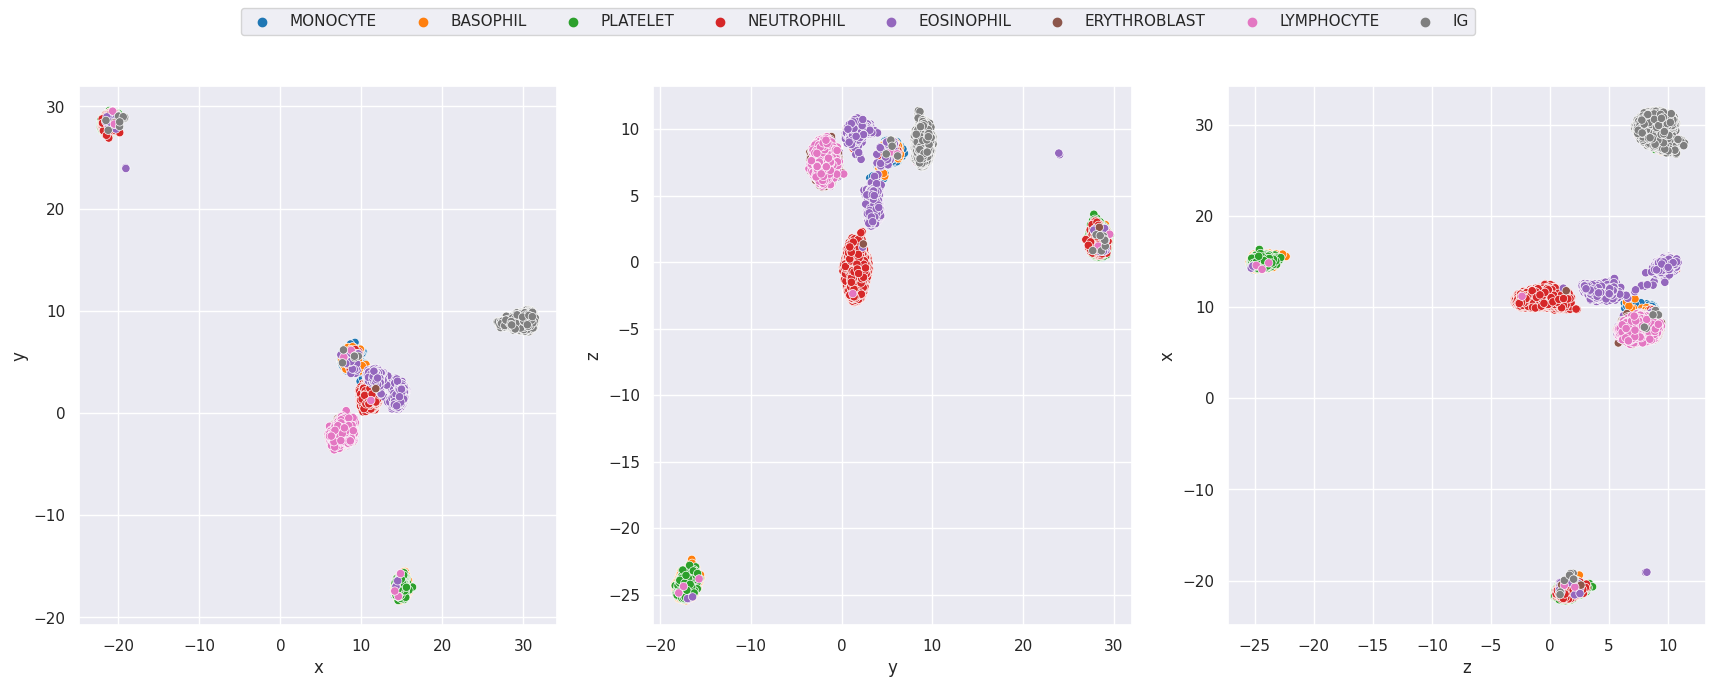

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7))
sns.scatterplot(x=umap.x, y=umap.y, hue=meta['group'], palette=palette, ax=ax1)
sns.scatterplot(x=umap.y, y=umap.z, hue=meta['group'], palette=palette, ax=ax2)
sns.scatterplot(x=umap.z, y=umap.x, hue=meta['group'], palette=palette, ax=ax3)

ax1.get_legend().remove(); ax2.get_legend().remove(), ax3.get_legend().remove()
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=meta['group'].nunique())
plt.show()

Nous allons donc essayer de supprimer les valeurs aberrantes et garder un jeu de données balancées pour essayer d'y voir plus clair dans les graphiques.

## 3. Nettoyage des données

Nous commencons par calculer le centroid de chaque groupe de cellules puis calculons la distance de chaque point avec son centre. Le graphique ci-dessous confirme qu'un grand nombre d'images est classé très loin de la borne haute.

Le nettoyage des données se fera en 2 étapes :
1. Suppression des images en dehors des limites de Tukey `q1 - 1.5 * iqr` et `q3 + 1.5 * iqr`.
2. Sous-échantillonnage (undersampling) pour rééquilibrer les groupes d'images par tirage aléatoire des images.

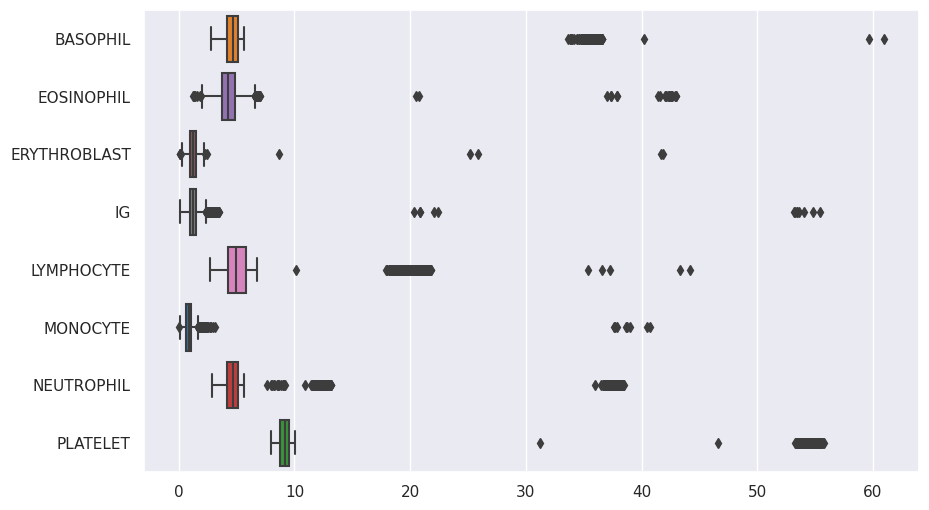

In [6]:
# Compute distance from centroids for each group
mean = umap.groupby(meta['group']).transform('mean')
dist = umap.sub(mean).pow(2).sum(axis=1).pow(0.5)

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x=dist, y=meta['group'].rename(None), order=sorted(meta['group'].unique()), ax=ax, palette=palette)
plt.show()

In [7]:
# Find outliers (Tukey fences)
q1, q3 = dist.groupby(meta['group']).quantile([0.25, 0.75]) \
             .unstack().to_dict('series').values()
lb, ub = q1 - 1.5 * (q3 - q1), q3 + 1.5 * (q3 - q1)
outliers = (dist > meta['group'].map(ub)) | (dist < meta['group'].map(lb))

# Remove outliers
data = umap[~outliers]
target = meta.loc[~outliers, 'group']

# Undersampling
data = data.groupby(target).sample(n=target.value_counts().min(), random_state=2022)
target = target[data.index]

In [8]:
outliers.sum() / len(umap) * 100

8.354785864732039

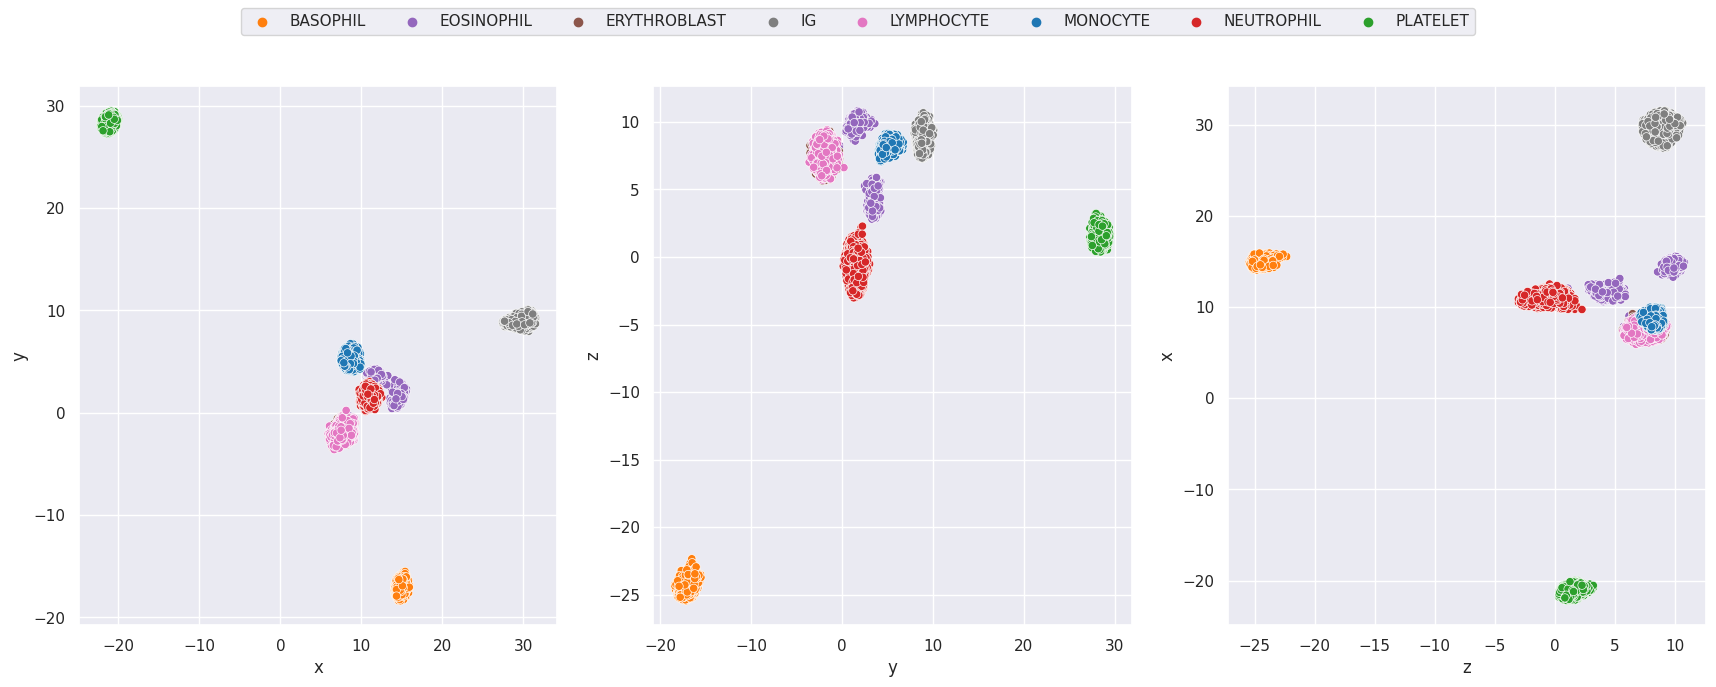

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7))
sns.scatterplot(x=data.x, y=data.y, hue=target, palette=palette, ax=ax1)
sns.scatterplot(x=data.y, y=data.z, hue=target, palette=palette, ax=ax2)
sns.scatterplot(x=data.z, y=data.x, hue=target, palette=palette, ax=ax3)

ax1.get_legend().remove(); ax2.get_legend().remove(), ax3.get_legend().remove()
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=target.nunique())
plt.show()

### Densité de distribution

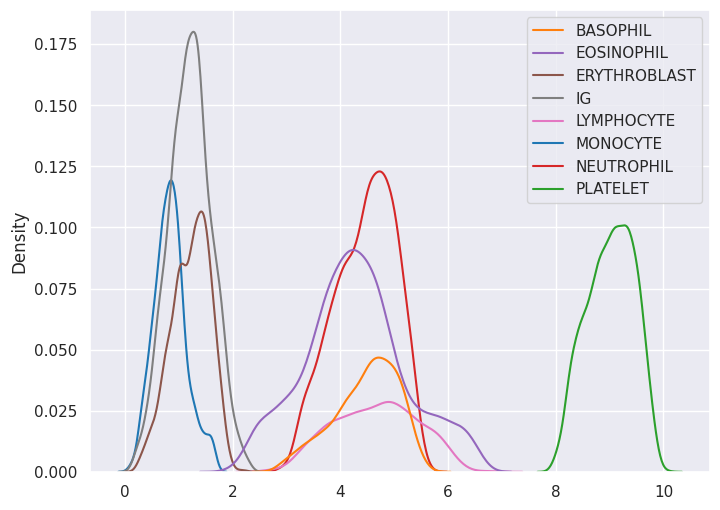

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.kdeplot(x=dist[~outliers], hue=meta.loc[~outliers, 'group'].rename(None),
            hue_order=sorted(meta['group'].unique()), ax=ax, palette=palette)
plt.show()

## 4. Modèles simples de classification

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=2022)

In [12]:
knn = KNeighborsClassifier()

knn_params = {'n_neighbors': np.linspace(10, 50, 9, dtype='int'),
              'metric': ['euclidean', 'minkowski']}

knn = GridSearchCV(KNeighborsClassifier(), param_grid=knn_params)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print(f'KNN score: {knn.score(X_test, y_test)}')
print(f'Best params: {knn.best_params_}')
cm_knn = pd.crosstab(y_test, y_pred_knn, rownames=['Real'], colnames=['Pred'])
cm_knn

KNN score: 0.8464467005076142
Best params: {'metric': 'euclidean', 'n_neighbors': 35}


Pred,BASOPHIL,EOSINOPHIL,ERYTHROBLAST,IG,LYMPHOCYTE,MONOCYTE,NEUTROPHIL,PLATELET
Real,,,,,,,,
BASOPHIL,205,0,0,0,0,0,0,0
EOSINOPHIL,0,146,29,0,15,1,0,0
ERYTHROBLAST,0,0,107,0,83,0,0,0
IG,0,0,0,184,0,0,0,0
LYMPHOCYTE,0,0,114,0,93,0,0,0
MONOCYTE,0,0,0,0,0,197,0,0
NEUTROPHIL,0,0,0,0,0,0,206,0
PLATELET,0,0,0,0,0,0,0,196


In [13]:
svc_params = {'C': [0.1, 1, 2, 5, 10],
              'kernel': ['linear', 'poly', 'rbf']}
svc = SVC()

svc = GridSearchCV(SVC(), param_grid=svc_params)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
print(f'SVC score: {svc.score(X_test, y_test)}')
print(f'Best params: {svc.best_params_}')
cm_svc = pd.crosstab(y_test, y_pred_svc, rownames=['Real'], colnames=['Pred'])
cm_svc

SVC score: 0.8401015228426396
Best params: {'C': 0.1, 'kernel': 'linear'}


Pred,BASOPHIL,EOSINOPHIL,ERYTHROBLAST,IG,LYMPHOCYTE,MONOCYTE,NEUTROPHIL,PLATELET
Real,,,,,,,,
BASOPHIL,205,0,0,0,0,0,0,0
EOSINOPHIL,0,146,30,0,14,1,0,0
ERYTHROBLAST,0,0,111,0,79,0,0,0
IG,0,0,0,184,0,0,0,0
LYMPHOCYTE,0,0,128,0,79,0,0,0
MONOCYTE,0,0,0,0,0,197,0,0
NEUTROPHIL,0,0,0,0,0,0,206,0
PLATELET,0,0,0,0,0,0,0,196
